## Import necessary modules

In [1]:
#Do all the imports and downloads:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import requests

!conda config --set channel_priority true

!conda config --set channel_priority false

!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

print('All modules installed and imported!')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_0         143 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    widgetsnbextension-3.5.1   |   py37h89c1867_4         1.8 MB  conda-forge
    ------------------------------------------------------------
          

## Begin with retrieving venues accross Manhattan from Foursquare

As we can only search venues in a radius around a certain point,we will define multiple
search points starting from Lower Manhattan all the way to Upper Manhattan.
    - Biggest distance from West to East Side is ~4.2km/2.6 miles
    - Therefore the Foursquare search radius will be 2,100 meters/1.3 miles
    - Search points will be in a distance of ~4.2km/2.6miles
By this, whole Manhattan should be covered.
We will use the term 'Restaurant' as seach query to filter only on food locations.

In [2]:
#Empty Dataframe in case it already exists:
#ny_search_areas.iloc[0:0]

#define the dataframe columns
column_names = ['Location', 'Latitude', 'Longitude'] 

#instantiate the dataframe
ny_search_areas = pd.DataFrame(columns=column_names)

#Fill the search Dataframe with the selected central locations in Manhattan 
append_row = {'Location':'Manhattan Bridge/Canal St.', 'Latitude':40.716102, 'Longitude':-73.996116}
ny_search_areas = ny_search_areas.append(append_row, ignore_index=True)
append_row = {'Location':'Empire State Building', 'Latitude':40.748049, 'Longitude':-73.984937}
ny_search_areas = ny_search_areas.append(append_row, ignore_index=True)
append_row = {'Location':'Met', 'Latitude':40.778918, 'Longitude':-73.962398}
ny_search_areas = ny_search_areas.append(append_row, ignore_index=True)
append_row = {'Location':'125St./Lexington Metro Station', 'Latitude':40.810673, 'Longitude':-73.952723}
ny_search_areas = ny_search_areas.append(append_row, ignore_index=True)
append_row = {'Location':'155St./St.Nicholas Metro Station', 'Latitude':40.830956, 'Longitude':-73.941475}
ny_search_areas = ny_search_areas.append(append_row, ignore_index=True)
append_row = {'Location':'191St. Metro Station', 'Latitude':40.856518, 'Longitude':-73.932922}
ny_search_areas = ny_search_areas.append(append_row, ignore_index=True)


ny_search_areas

,Location,Latitude,Longitude
0,Manhattan Bridge/Canal St.,40.716102,-73.996116
1,Empire State Building,40.748049,-73.984937
2,Met,40.778918,-73.962398
3,125St./Lexington Metro Station,40.810673,-73.952723
4,155St./St.Nicholas Metro Station,40.830956,-73.941475
5,191St. Metro Station,40.856518,-73.932922


## Now define the Foursquare access credentials and search queries

Following cell is hidden, as it contains the Foursquare access data.

In [3]:
# The code was removed by Watson Studio for sharing.

## Re-use the given function for retrieving venues, set radius to te discussed 2.1km:

In [4]:
#Following function was given in Module 3, adjusted with bigger radius, searching for restaurants only and additionally querying the venue ID:
def getNearbyVenues(names, latitudes, longitudes, radius=2100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            QUERY,
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    # transform the results to a DataFrame
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Search Point', 
                  'Search Point Latitude', 
                  'Search Point Longitude',
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


 ## Run the function and retrieve venues:

In [5]:
# call the above function for all defined search areas:
manhattan_venues = getNearbyVenues(names=ny_search_areas['Location'],
                                   latitudes=ny_search_areas['Latitude'],
                                   longitudes=ny_search_areas['Longitude']
                                  )
print('Retrieved venues for all search points')

Manhattan Bridge/Canal St.
Empire State Building
Met
125St./Lexington Metro Station
155St./St.Nicholas Metro Station
191St. Metro Station
Retrieved venues for all search points


In [6]:
#Check out the retrieved data:
print(manhattan_venues.shape)
print(manhattan_venues.dtypes)

(600, 8)
Search Point               object
Search Point Latitude     float64
Search Point Longitude    float64
Venue ID                   object
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
dtype: object


###  Notice that we retrieved 'only' 600 results - 100 per location
### This is obviously not enough for a really comprehensive analysis of whole Manhattan. But due to the limitation of Premium calls we can not query more than 500 venues per day anyways.

In [27]:
# reduce the data set in column size
# also reduce the rows to adjust to the Premium Calls
manhattan_eats = pd.DataFrame()
manhattan_eats = manhattan_venues[['Venue ID','Venue','Venue Latitude','Venue Longitude','Venue Category']]
manhattan_eats_score = manhattan_eats.head(400)
manhattan_eats_score.shape

(400, 5)

## Define API query for getting each venue's score: 

In [8]:
   def getVenuesScore(IDs):
    
    venues_scores=[]
    for venue_id in IDs:
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
        print(url)
        
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['venue']['rating']
        except:
            results = 'No rating'

        # return only relevant information for each nearby venue
        venues_scores.append(([
            venue_id, 
            results]))

    venues_scores=pd.DataFrame(venues_scores,columns = ['Venue ID', 'Venue Score'])
    
    return(venues_scores)


## Execute query for first 400 venues - due to limitations on Premium Calls with Foursquare:

In [38]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Venue ID,Venue Score
0,0,5894c9a15e56b417cf79e553,8.9
1,1,3fd66200f964a520bce61ee3,8.9
2,2,5c965dad5455b2002c058659,8.9
3,3,4a00e0a7f964a520bc701fe3,8.8
4,4,4bcf9774a8b3a5939497625f,8.9
5,5,5cc4e9d0c876c8002c3010cb,9.4
6,6,5521c2ff498ebe2368634187,9.2
7,7,4b1896caf964a52069d423e3,9.0
8,8,5f5e1b49af65ef27d803a4f0,9.3
9,9,56c3c626cd106998d2b196d0,9.1


In [39]:
# reset the index to prepare list merge

scores=scores.set_index('Venue ID',drop=True)
scores=scores.drop(scores.columns[0], axis=1)
scores.head()

,Venue Score
Venue ID,
5894c9a15e56b417cf79e553,8.9
3fd66200f964a520bce61ee3,8.9
5c965dad5455b2002c058659,8.9
4a00e0a7f964a520bc701fe3,8.8
4bcf9774a8b3a5939497625f,8.9


## Explore the retrieved data

In [40]:
# check the basic statistics via describe
scores['Venue Score'].describe()

count    401.000000
mean       8.674065
std        0.412524
min        7.400000
25%        8.400000
50%        8.800000
75%        9.000000
max        9.500000
Name: Venue Score, dtype: float64

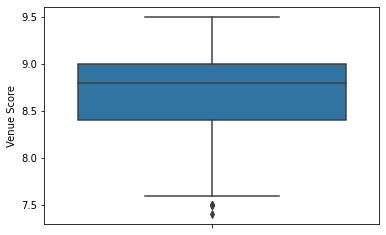

In [41]:
# illustrate the distribution of venue scores via a boxplot
sns.boxplot( y='Venue Score', data=scores)

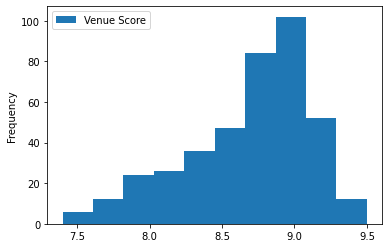

In [46]:
#check the histogram for more insights: 
scores.plot.hist()

In [47]:
# as we saw the scores are not equally distributed - normalize them using Z-score for better results
scores['Venue Score']=(scores['Venue Score']-scores['Venue Score'].mean())/scores['Venue Score'].std()
scores.head()

,Venue Score
Venue ID,
5894c9a15e56b417cf79e553,0.54769
3fd66200f964a520bce61ee3,0.54769
5c965dad5455b2002c058659,0.54769
4a00e0a7f964a520bc701fe3,0.30528
4bcf9774a8b3a5939497625f,0.54769


## Now check again the statistics of scores after the normalization:

In [48]:
# check the basic statistics via describe
scores['Venue Score'].describe()

count    4.010000e+02
mean    -2.905960e-15
std      1.000000e+00
min     -3.088466e+00
25%     -6.643617e-01
50%      3.052799e-01
75%      7.901007e-01
max      2.002153e+00
Name: Venue Score, dtype: float64

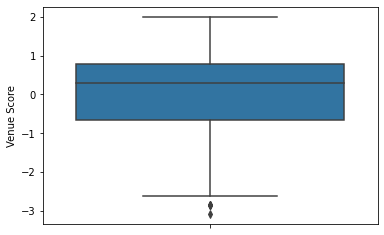

In [49]:
# illustrate the distribution of venue scores via a boxplot
sns.boxplot( y='Venue Score', data=scores)

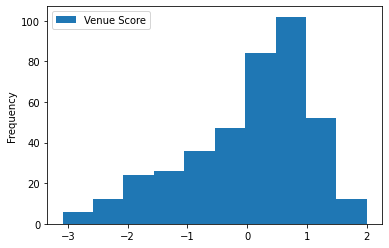

In [50]:
#check the histogram for more insights: 
scores.plot.hist()

## Merge list of with venues scores with the existing list including their coordinates:

In [51]:
#reset the indexes
manhattan_eats_score.set_index('Venue ID',inplace=True)
manhattan_eats_score = manhattan_eats_score.join(scores)
manhattan_eats_score.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Score
Venue ID,,,,,
5894c9a15e56b417cf79e553,Xi'an Famous Foods,40.715232,-73.997263,Chinese Restaurant,0.54769
3fd66200f964a520bce61ee3,La Bella Ferrara,40.717450,-73.998373,Bakery,0.54769
5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp,40.718254,-73.995930,Chinese Restaurant,0.54769
4a00e0a7f964a520bc701fe3,Singapore Malaysia Beef Jerky,40.718527,-73.995824,Snack Place,0.30528
4bcf9774a8b3a5939497625f,Shanghai 21,40.714423,-73.998904,Shanghai Restaurant,0.54769


In [52]:
# now check again the statistics of our data:
manhattan_eats_score.describe()

,Venue Latitude,Venue Longitude,Venue Score
count,400.000000,400.000000,397.000000
mean,40.763141,-73.973225,0.006694
std,0.033904,0.018877,0.998792
min,40.708280,-74.009070,-3.088466
25%,40.734868,-73.988835,-0.664362
50%,40.762754,-73.975644,0.305280
75%,40.789827,-73.955237,0.790101
max,40.823084,-73.940516,2.002153


In [54]:
# probably due to some duplicates we lost 3 score that could not be joined. Drop these NaN values
manhattan_eats_score.dropna(inplace=True)
manhattan_eats_score.describe()

,Venue Latitude,Venue Longitude,Venue Score
count,397.000000,397.000000,397.000000
mean,40.763027,-73.973277,0.006694
std,0.033927,0.018900,0.998792
min,40.708280,-74.009070,-3.088466
25%,40.726316,-73.988850,-0.664362
50%,40.758679,-73.975666,0.305280
75%,40.787679,-73.955284,0.790101
max,40.823084,-73.940516,2.002153


## Build a heatmap of Manhattan with the retrieved scores:

In [55]:
# generate the Folium map, centered on Manhattan
ny_map = folium.Map(width=1500,height=900, location=[40.7896239, -73.9598939], zoom_start=12)

# retrieve the coordinates and the score value from the data set
heat_data = [[row['Venue Latitude'],row['Venue Longitude'],row['Venue Score']] for index, row in manhattan_eats_score.iterrows()]

# add the HeatMap-Overlay to the map
HeatMap(heat_data).add_to(ny_map)

# add the search points as markers on the map for orientation
for lat, lng, label in zip(ny_search_areas['Latitude'], ny_search_areas['Longitude'], ny_search_areas['Location']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ny_map)  

# show the map    
ny_map